# Test on Hold out Set
Score models and evaluate

In [1]:
import logging
import os

import matplotlib.font_manager as mfm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

from config import Project
from src.audio import Audio
from src.custom_loss import conv_loss
from src.display import Disp
from src.kss_df import KssDfType, make_kss_df_cls
from src.kss_speech import KssSpeech
from src.scorers import ConvVar
from src.versioner import FileVersioner, VersionFinder
from src.model_wrapper import ModelWrapper
from src.shared_params import SharedParams

In [2]:
font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Saved Models

SciKitLearn and Keras models are supported.

Models are trained and saved by the notebooks in the `./models` directory.

Trained models are saved to the `<root>/data/model` directory.

In [3]:

# Load the save models

# TODO: Is there a better way? This is needed so that the custom 'conv_loss' function is registered
# See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'conv_loss': conv_loss})

def get_ext(model_file):
    return model_file.split('.')[-1]

def get_wrapper(f):
    model_name = f.replace('.ipynb', '')
    fv = FileVersioner(Project.path.MODEL, model_name, 'wrapper')
    path = fv.get_saved_path()
    return ModelWrapper.load(path)

def get_kss_event_detection_rms_wrappers():
    fs = os.listdir(Project.path.KSS_EVENT_RMS_MODEL)
    return [get_wrapper(f) for f in fs if f.endswith('ipynb')]

wrappers = get_kss_event_detection_rms_wrappers()

print(f'Saved Model Dir: {Project.path.MODEL}')
print(f'Available Models {[w.id for w in wrappers]}')


Saved Model Dir: /Users/dev/Projects/korean-ml/data/model
Available Models ['cnn', 'tree', 'vote-ada-sw', 'svr-rbf', 'ada', 'logr']


In [4]:
class MatchNotebooksToModels:

    @classmethod
    def get_file_ext(cls, model_file):
        return model_file.split('.')[-1]

    @classmethod
    def get_file_base(cls, model_file):
        model_fname = os.path.basename(model_file)
        return model_file.split('.')[0]

    def __init__(self, notebook_dir, model_dir):
        self.notebook_dir = notebook_dir
        self.model_dir = model_dir
        self.notebook_entries = os.listdir(notebook_dir)
        self.saved_model_entries = os.listdir(model_dir)

    def is_model_entry(self, entry, model_name):
        model_part = self.get_file_base(entry)
        return model_part == model_name

    def get_saved_models(self, model_name):
        return [f for f in self.saved_model_entries if self.is_model_entry(f, model_name)]

    def get_version_ext(self, model_name):
        """
        All versions of a saved model should have the same extension
        """
        saved_model_filenames = self.get_saved_models(model_name)
        all_exts = [self.get_file_ext(f) for f in saved_model_filenames]
        print(all_exts, model_name, saved_model_filenames)
        matching_exts = set(all_exts)
        print(matching_exts)
        if len(matching_exts) == 0:
            raise ValueError(f'No matching extensions found for {model_name}')
        if len(matching_exts) > 1:
            raise ValueError(f'model_name: {model_name} should only have one extension but found: {list(matching_exts)}')
        assert len(matching_exts) == 1, f'{model_name} extension list is the wrong length: {list(matching_exts)}'
        matching_set = matching_exts.pop()
        print(type(matching_set))
        return matching_set

    def nb_has_saved_model(self, nb_name):
        model_name = nb_name.replace('.ipynb', '')
        return len([f for f in self.saved_model_entries if f.startswith(model_name)]) > 0

    def filter_notebooks(self):
        return [nb for nb in self.notebook_entries if self.nb_has_saved_model(nb)]

    # def find_model_versions(self, model_names):
    #     return [(m, self.get_version_ext(m)) for m in model_names]

    def notebooks_to_model_names(self):
        return [f.replace('.ipynb', '') for f in self.filter_notebooks()]

    def find_model_and_exts(self):
        return [(m, self.get_version_ext(m)) for m in self.notebooks_to_model_names()]

    def derive_transformer_path(self, model, basename):
        transformer_path = None
        txfm_basename = basename.replace(model, f'{model}-transformer')
        lookup_path = os.path.join(self.model_dir, txfm_basename)
        print('lookup path', lookup_path)
        if os.path.exists(lookup_path):
            transformer_path = lookup_path
        return transformer_path

    def find_paths(self):
        vfs = [VersionFinder(model, ext) for model, ext in self.find_model_and_exts()]
        latest_models =  [(vf.base, vf.get_latest_name_and_version(self.saved_model_entries)[0]) for vf in vfs]
        # I don't like this approach that much, but it's pretty incremental to existing code
        # this approach == implied transformer name, and it being an unnamed tuple to the model
        print('finding paths')
        return [(model, os.path.join(self.model_dir, fname), self.derive_transformer_path(model, vsn_name)) for model, vsn_name in latest_models]

In [5]:

# Load Shared Parameters
# fv_shared_params = FileVersioner(Project.path.MODEL, 'shared_params', 'joblib')
shared_params = SharedParams(Project.path.MODEL).load()


## Get X, y Test Data from KSS Ids

In [6]:
KssDf = make_kss_df_cls(Project.path.TEXTGRID, Project.path.KSSCSV)

kss_tst_ids = shared_params['kss']['tst_ids']
audio_params = shared_params['audio']

kdfs = [KssDf(id) for id in kss_tst_ids]

X_tst_list = [Audio(kdf.audio_path, **audio_params).rms.squeeze() for kdf in kdfs]

def kss_speech_maker(kdf, **kwargs):
    a = Audio(kdf.audio_path, **kwargs)

    print(2, logging.getLogger("Audio"))
    assert a.sr == audio_params['sr'], f'Mismatch sample rate, expected {audio_params["sr"]}, but got {a.sr} for {kdf.audio_path}'
    df = kdf.load_csv(type=KssDfType.SYL)
    return KssSpeech(df, a)

#y_tst_list is the ground truth y values
y_tst_list = [ kss_speech_maker(kdf).is_speech for kdf in kdfs]


Audio[WARNING]: Modifying input wav from size 121857 to 121920
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[WARNING]: Modifying input wav from size 154852 to 154880
Audio[WARNING]: Modifying input wav from size 121857 to 121920
Audio[WARNING]: Modifying input wav from size 154852 to 154880


2 <Logger Audio (WARNING)>
2 <Logger Audio (WARNING)>


### Predict and Score
For each model of interest, get the predictions and score it against the ground truth



KerasModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
KerasModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
KerasModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
KerasModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
ModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
ModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
ModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
ModelWrapper[INFO]: transformed X, y shapes: (1906, 128), (1906,)
transform() from the base Transformer class called. This does nothing.
ModelWrapper[INFO]: transformed X, y shapes: (1906,), (1906,)
transform() from the base Transformer class called. This does nothing.
ModelWrapper[INFO]: transformed X, y shapes: (1906,), (1906,)
transform() from the base Transformer class called. This does nothing.
ModelWrapper[INFO]: transformed X, y shapes: (1906,), (1906,)
transform() from the base Transformer class called. T

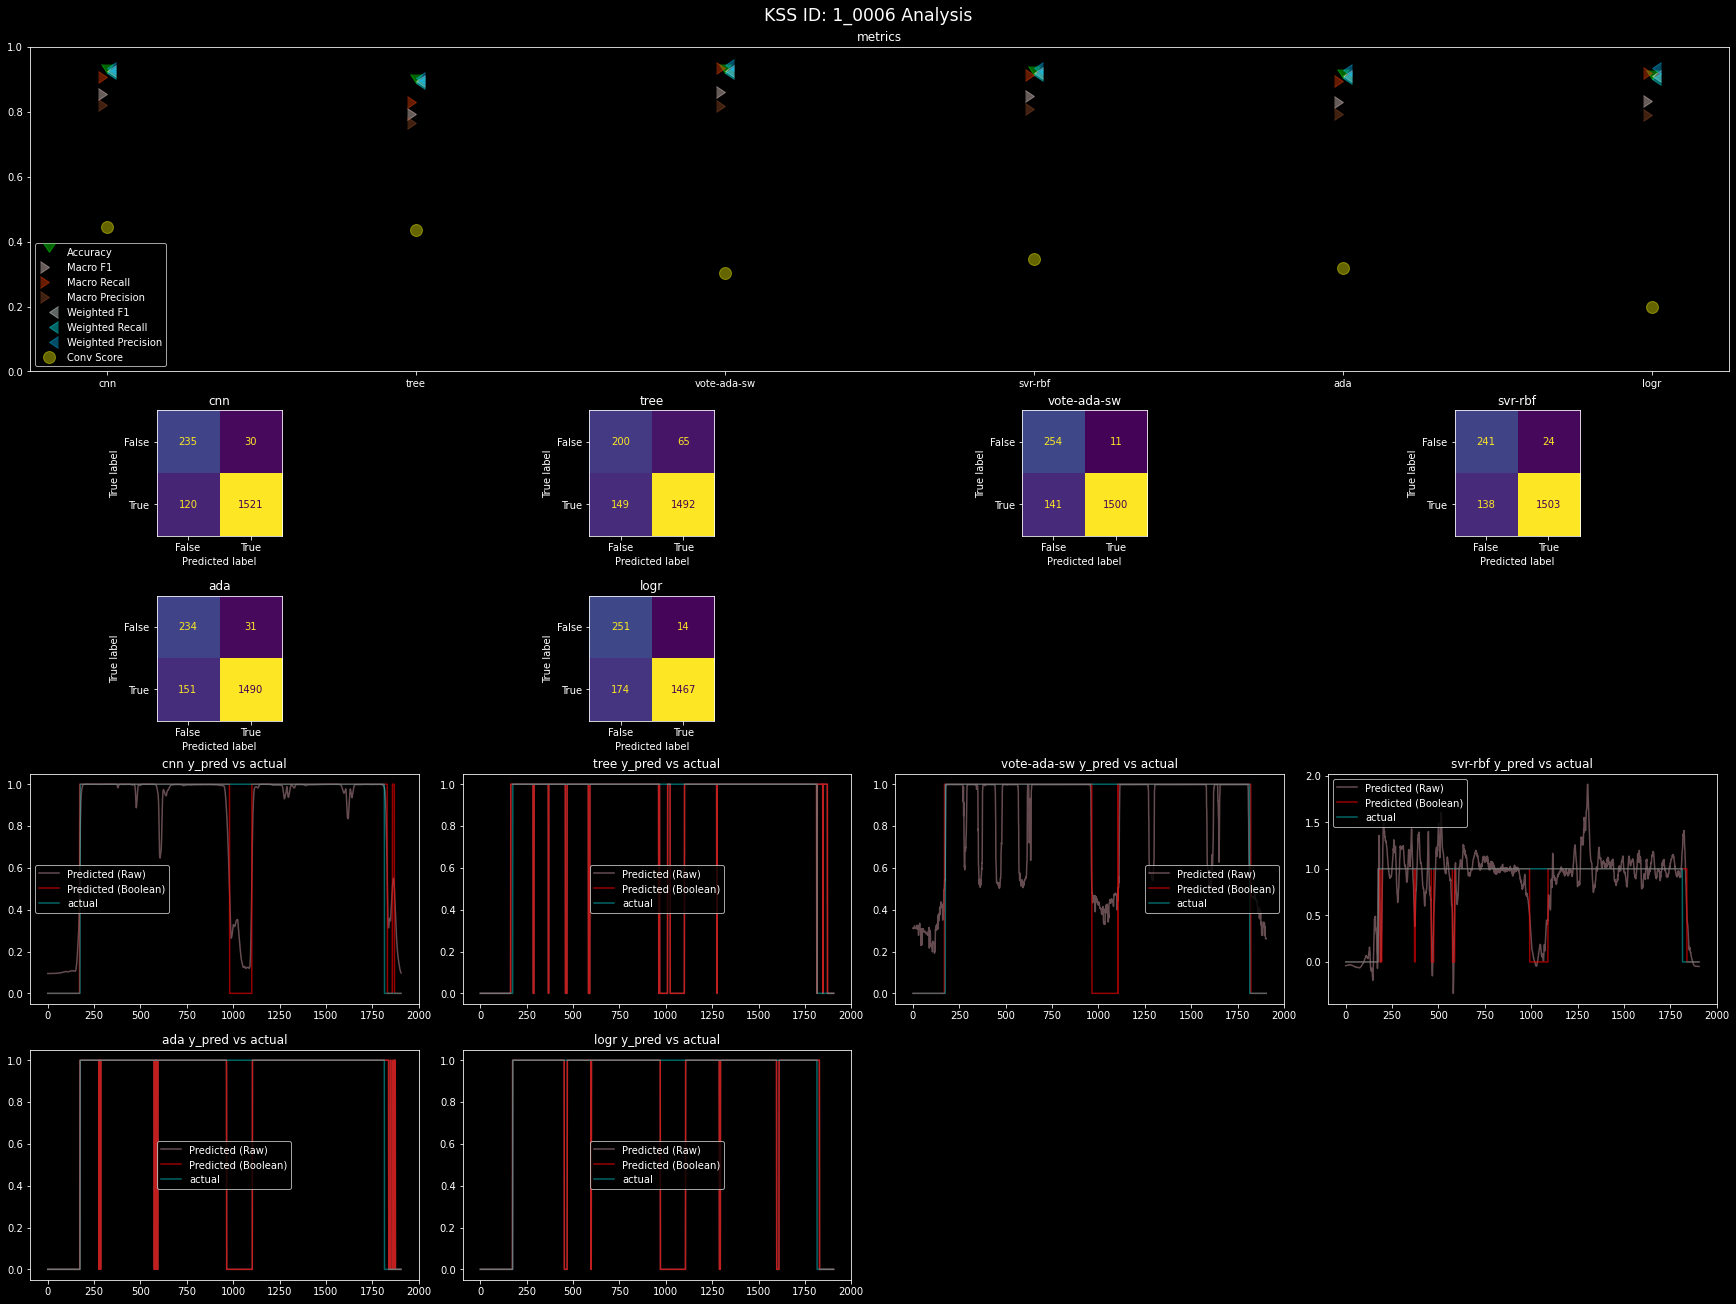

KerasModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
KerasModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
KerasModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
KerasModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
ModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
ModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
ModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
ModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
transform() from the base Transformer class called. This does nothing.
ModelWrapper[INFO]: transformed X, y shapes: (2421,), (2421,)
transform() from the base Transformer class called. This does nothing.
ModelWrapper[INFO]: transformed X, y shapes: (2421,), (2421,)
transform() from the base Transformer class called. This does nothing.
ModelWrapper[INFO]: transformed X, y shapes: (2421,), (2421,)
transform() from the base Transformer class called. T

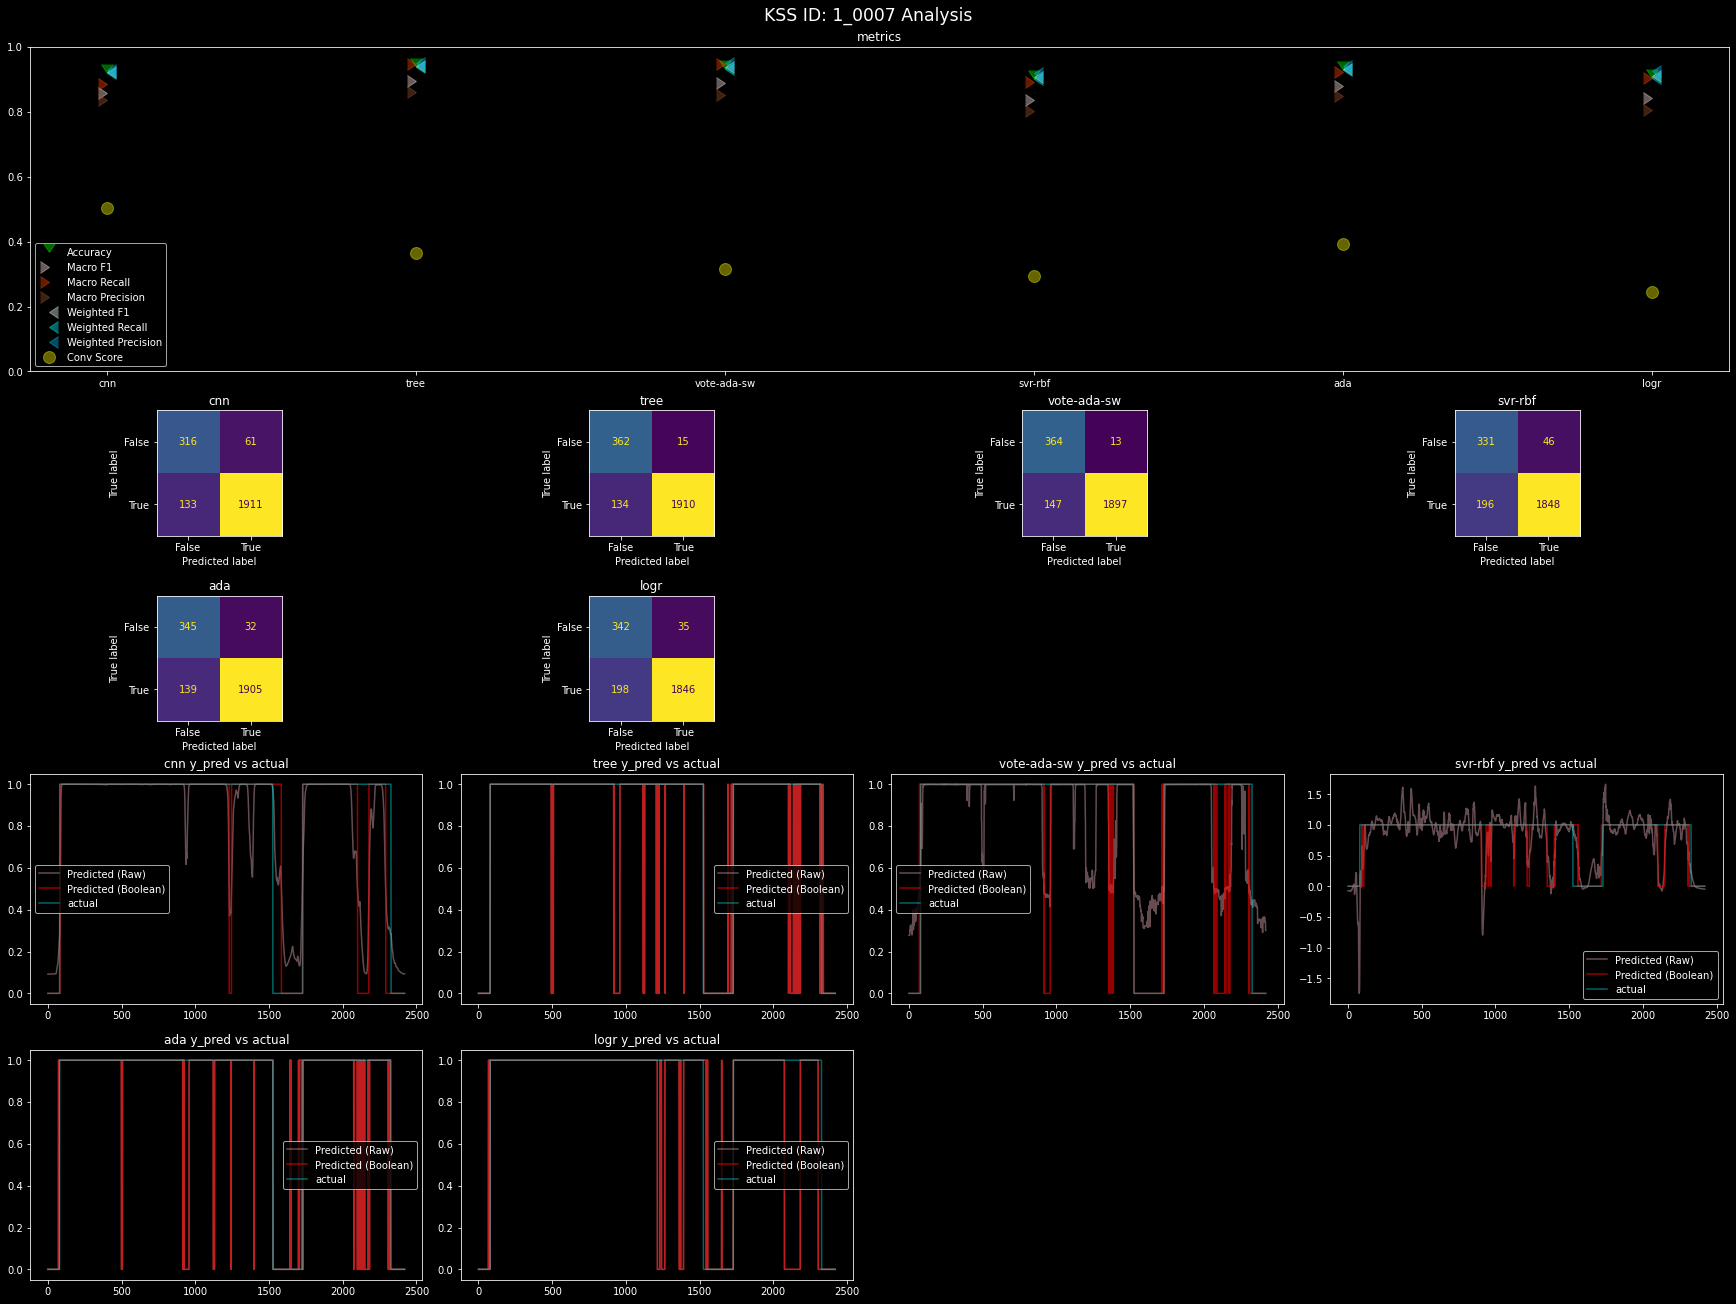

In [7]:
# Change log verbosity
logging.getLogger("SlidingWindow").setLevel(logging.WARNING)
logging.getLogger("KerasTransform").setLevel(logging.WARNING)
logging.getLogger("BaseTransform").setLevel(logging.WARNING)


# TODO: Find Keras equivalent to classification report
from sklearn.metrics import classification_report

def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, 1.0, 0.0)

def get_metrics(model, X_tst, y_tst):
    y_pred = pred_threshold(model.predict(X_tst))
    report = classification_report(y_tst.squeeze(), y_pred.squeeze(), output_dict=True)
    return report

def calc_sub_gs(tot_plots, max_per_row):
    cols = max_per_row
    rows = 1 + tot_plots // max_per_row
    return rows, cols

mod_names = [w.id for w in wrappers]
# TODO: Replace mods with wrappers
mods = [w for w in wrappers]
num_mods = len(mods)

conv_var = ConvVar(var_penalty=20)

# Plot Layout (per KSS ID)
base_rows = 3
base_cols = 1
cm_plots_per_row = 4
pred_plots_per_row = 4
height_ratios = [2 ,2, 3]  # number of elements must match base_rows
figsize=(24, 18)

for i, kdf in enumerate(kdfs):
    plt.close('all')
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    fig.suptitle(f'KSS ID: {kdf.id} Analysis', fontsize='xx-large')

    # base gridspec
    gs = fig.add_gridspec(base_rows, base_cols, height_ratios=height_ratios)

    # metrics gridspec
    gs0 = gs[0].subgridspec(1,1)

    # confusion matrix gridspec
    gs1 = gs[1].subgridspec(*calc_sub_gs(num_mods, cm_plots_per_row))

    # pred vs actual gridspec
    gs2 = gs[2].subgridspec(*calc_sub_gs(num_mods, pred_plots_per_row))

    # Metrics axis
    ax = fig.add_subplot(gs0[0,0])
    ax.set_ylim(0.0,1)
    ax.set_title('metrics')
    ax.set_xticks(np.arange(len(mod_names)))
    ax.set_xticklabels(mod_names)

    accuracy = []
    macro_f1 = []
    macro_recall = [] #'macro avg''recall'
    macro_precision = []
    weighted_f1 = []
    weighted_recall = []
    weighted_precision = []
    conv_scores = []


    for j, m in enumerate(mods):
        metrics = get_metrics(m, X_tst_list[i], y_tst_list[i])
        accuracy.append(metrics['accuracy'])
        macro_f1.append(metrics['macro avg']['f1-score'])
        macro_recall.append(metrics['macro avg']['recall'])
        macro_precision.append(metrics['macro avg']['precision'])
        weighted_f1.append(metrics['weighted avg']['f1-score'])
        weighted_recall.append(metrics['weighted avg']['recall'])
        weighted_precision.append(metrics['weighted avg']['precision'])

        _y_tst = y_tst_list[i].squeeze()
        _y_pred = pred_threshold(m.predict(X_tst_list[i]).squeeze())

        conv_score = conv_var.score(_y_tst, _y_pred )
        conv_scores.append(conv_score)

        # Confusion Matrix
        cm_plt_row = j // cm_plots_per_row
        cm_plt_col = j % cm_plots_per_row
        cm = ConfusionMatrixDisplay.from_predictions(_y_tst, _y_pred, ax=fig.add_subplot(gs1[cm_plt_row,cm_plt_col]), colorbar=False)
        cm.ax_.set_title(f'{mod_names[j]}')
        cm.im_.set_clim(0, 1165)

        # Predicted vs Actual
        pred_plt_row = j // pred_plots_per_row
        pred_plt_col = j % pred_plots_per_row
        ax2 = fig.add_subplot(gs2[pred_plt_row,pred_plt_col])
        ax2.plot(m.predict(X_tst_list[i]), color='pink', alpha=0.4, label='Predicted (Raw)')
        ax2.plot(pred_threshold( m.predict(X_tst_list[i])), color='red', alpha=0.6, label='Predicted (Boolean)')
        ax2.plot(y_tst_list[i], alpha=0.4, color='cyan', label='actual')
        ax2.set_title(f'{mod_names[j]} y_pred vs actual')
        ax2.legend()

    ax.plot(accuracy, label='Accuracy', color='lime', alpha=0.4, linestyle='None', marker=7, markersize=12)
    ax.plot(macro_f1, label='Macro F1', color='mistyrose', alpha=0.4, linestyle='None', marker=5, markersize=12)
    ax.plot(macro_recall, label='Macro Recall', color='orangered', alpha=0.4, linestyle='None', marker=5, markersize=12)
    ax.plot(macro_precision, label='Macro Precision', color='sienna', alpha=0.4, linestyle='None', marker=5, markersize=12)
    ax.plot(weighted_f1, label='Weighted F1', color='azure', alpha=0.4, linestyle='None', marker=4, markersize=12)
    ax.plot(weighted_recall, label='Weighted Recall', color='cyan', alpha=0.4, linestyle='None', marker=4, markersize=12)
    ax.plot(weighted_precision, label='Weighted Precision', alpha=0.4, color='deepskyblue', linestyle='None', marker=4, markersize=12)
    ax.plot(conv_scores, label='Conv Score', alpha=0.4, color='yellow', linestyle='None', marker='o', markersize=12)
    ax.legend()

    plt.show()
